# Определение факторов успешности компьютерных игр

**Описание проекта**

Я сотрудник интернет-магазина "Стримчик", который продает по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы. В процессе выполнения проекта, нужно выявить закономерности определяющие успешность игр. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании на следующий год.

В нашем распоряжении данные до 2016г. Нам необходимо спланировать кампанию на 2017г.

## Изучение данных из файла

В самом начале импортируем все необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
games = pd.read_csv('/datasets/games.csv') #чтение файла

In [3]:
display(games.head(10)) # просмотр первых 10 строк

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


Уже по первым 10 строкам видно, что в данных пропущены значения. В наименованиях столбцов использованы разные регистры. Посмотрим общую информацию о файле:

In [4]:
games.info() # просмотр информации о файле

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


В файле 11 столбцов. Тип данных в 5 столбцах - object, в 6-ти - float64

В соответствии с документацией в файле есть следующие данные:
- Name - название игры
- Platform - платформа
- Year_of_Release - год выпуска
- Genre- жанр игры
- NA_sales - продажи в Северной Америке (млн.проданных копий)
- EU_sales - продажи в Европе (млн. проданных копий)
- JP_sales - продажи в Японии (млн.проданных копий)
- Other_sales - продажи в других странах (млн.проданных копий)
- Critic_Score -оценки критиков (максимум 100)
- User_Score - оценки пользователей (максимум 10)
- Rating - рейтинг от организации ESRB. Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию    

Предварительно можно сказать, что в столбце с годом выпуска игры (Year_of_Release) нужно заменить тип данных на числовой, а в столбце с оценками пользователей заменить тип на вещественный. Также видно, что в данных есть пропуски, более подробно эту информацию посмотрим с помощью метода isna().sum():

In [5]:
games.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

Пропуски в названии игры и жанре возможно связаны, с тем что наименование было написано в таком формате, который не смогли перекодировать латиницей. Пропуски в оценках, скорее всего из-за их непосредственного отсутствия: критики и пользователи могли не оценивать эти игры, рейтинг ESRB характерен для США и Канады.

Проверим есть ли в файле полные дубликаты медодом duplicated().sum()

In [6]:
games.duplicated().sum() # проверка на наличие дубликатов и подсчет их количества

0

Полностью дублирующихся строк нет. Но возможно есть дублирующиеся названия игр.

In [7]:
games['Name'].value_counts()

Need for Speed: Most Wanted         12
Madden NFL 07                        9
FIFA 14                              9
LEGO Marvel Super Heroes             9
Ratatouille                          9
                                    ..
Romancing SaGa 2                     1
Paper Mario: Color Splash            1
L.A. Noire: The Complete Edition     1
Power Pro Kun Pocket 10              1
Fate/Tiger Colosseum Upper           1
Name: Name, Length: 11559, dtype: int64

Дублирующиеся названия есть. На примере Need for Speed: Most Wanted, посмотрим, что это за дубли:

In [8]:
display(games.loc[games['Name'] == 'Need for Speed: Most Wanted'])

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
253,Need for Speed: Most Wanted,PS2,2005.0,Racing,2.03,1.79,0.08,0.47,82.0,9.1,T
523,Need for Speed: Most Wanted,PS3,2012.0,Racing,0.71,1.46,0.06,0.58,NaN,NaN,NaN
1190,Need for Speed: Most Wanted,X360,2012.0,Racing,0.62,0.78,0.01,0.15,83.0,8.5,T
1591,Need for Speed: Most Wanted,X360,2005.0,Racing,1.00,0.13,0.02,0.10,83.0,8.5,T
1998,Need for Speed: Most Wanted,XB,2005.0,Racing,0.53,0.46,0.00,0.05,83.0,8.8,T
2048,Need for Speed: Most Wanted,PSV,2012.0,Racing,0.33,0.45,0.01,0.22,NaN,NaN,NaN
3581,Need for Speed: Most Wanted,GC,2005.0,Racing,0.43,0.11,0.00,0.02,80.0,9.1,T
5972,Need for Speed: Most Wanted,PC,2005.0,Racing,0.02,0.23,0.00,0.04,82.0,8.5,T
6273,Need for Speed: Most Wanted,WiiU,2013.0,Racing,0.13,0.12,0.00,0.02,NaN,NaN,NaN
6410,Need for Speed: Most Wanted,DS,2005.0,Racing,0.24,0.01,0.00,0.02,45.0,6.1,E


Дублирующиеся названия связаны с тем, что игры выходили на разных платформах или в разные годы и соответственно такие дубли удалять нельзя.

**Вывод**


Первый взгляд на данные выявил несколько проблем:
- названия столбцов написано в разных регистрах. 
- есть пропуски в данных.
- неподходящий тип данных в столбцах с годом выпуска игры и в столбце с оценками пользователей.

В следующем разделе мы постараемся исправить неточности в данных, заменим тип данных. А также посмотрим, не обнаружатся ли еще какие-нибудь "артефакты".

## Предобработка данных

### Приведение названий столбцов к нижнему регистру

Для начала посмотрим список столбцов, а затем произведем замену методом rename()

In [9]:
games.columns # просмотр названий столбцов

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'NA_sales', 'EU_sales',
       'JP_sales', 'Other_sales', 'Critic_Score', 'User_Score', 'Rating'],
      dtype='object')

In [10]:
games = games.rename(columns = {'Name': 'name', 'Platform': 'platform', 'Year_of_Release': 'year_of_release', 'Genre': 'genre', 'NA_sales': 'na_sales', 'EU_sales': 'eu_sales',
       'JP_sales': 'jp_sales', 'Other_sales': 'other_sales', 'Critic_Score': 'critic_score', 'User_Score': 'user_score', 'Rating': 'rating'}) # переименование столбцов

In [11]:
games.columns # просмотр названий столбцов

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

Замена названий прошла успешно.

### Обработка пропусков и замена типов данных

В данных есть две строчки, где нет названия игры и указания жанра. Такие строки можно спокойно удалить, потому что без названия и жанра, вся остальная информация не имеет смысла.

Строки с пропущенным значением года выпуска составляют 1,6% от общего количества. И поскольку в дальнейшем нам нужно строить анализ вокруг дат, то пропуски будут нам мешать. Считаю необходимым удалить и эти строки тоже.

In [12]:
games = games.dropna(subset =['name', 'year_of_release']) # удаление строк, где есть пропуски в указазных столбцах

Далее изменим тип данных в столбце с годом, на целочисленный - с таким форматом будет удобнее работать. Поскольку нам не нужно будет проводить никаких операций с датами, то переводить значение года в формат datetime64 мы не будем.

In [13]:
games['year_of_release'] = games['year_of_release'].astype('int') # замена объекта float64 на целочисленное значение

Поскольку в столбце с оценками пользователей изначально стоит тип данных object, то сначала посмотрим уникальные значения, чтобы убедится, что нас не ждут какие-нибудь неожиданности, которые помешают заменить тип данных.

In [14]:
games['user_score'].sort_values().unique() # просмотр уникальных значений

array(['0', '0.2', '0.3', '0.5', '0.6', '0.7', '0.9', '1', '1.1', '1.2',
       '1.3', '1.4', '1.5', '1.6', '1.7', '1.8', '1.9', '2', '2.1', '2.2',
       '2.3', '2.4', '2.5', '2.6', '2.7', '2.8', '2.9', '3', '3.1', '3.2',
       '3.3', '3.4', '3.5', '3.6', '3.7', '3.8', '3.9', '4', '4.1', '4.2',
       '4.3', '4.4', '4.5', '4.6', '4.7', '4.8', '4.9', '5', '5.1', '5.2',
       '5.3', '5.4', '5.5', '5.6', '5.7', '5.8', '5.9', '6', '6.1', '6.2',
       '6.3', '6.4', '6.5', '6.6', '6.7', '6.8', '6.9', '7', '7.1', '7.2',
       '7.3', '7.4', '7.5', '7.6', '7.7', '7.8', '7.9', '8', '8.1', '8.2',
       '8.3', '8.4', '8.5', '8.6', '8.7', '8.8', '8.9', '9', '9.1', '9.2',
       '9.3', '9.4', '9.5', '9.6', '9.7', 'tbd', nan], dtype=object)

В данных обнаружены tbd и nan. NaN - пропуск данных, который возник скорее всего, потому что пользователи еще не оценивали игру. Их можно заменить на 0. На медиану или среднее заменять не стоит, т.к. это не корректно, потому что оценки - это понятие субъективное и сложно просчитываемое. Даже две части одной игры или одна игра, но на разных платформах могут очень сильно разниться по отзывам.

tbd - означает "будет определен". Могу предположить, что данное значение означает, что оценки еще расчитываются, т.е слишком мало оценок для расчета или у игры вышло обновление (исправлены какие-то ошибки) и ожидается обновление оценок пользователей. В любом случае как и с NaN просчитать итоговую оценку мы не можем. Заменим данное значение на 0. 

На данном этапе можно немного облегчить себе жизнь и сначала заменить тип данных с object на float64 методом to_numeric() с параметром errors = 'coerce'. В этом случае все цифры будут преобразованы, а tbd будет заменено на NaN, затем мы заменим пропуски на 0

In [15]:
games['user_score'] = pd.to_numeric(games['user_score'], errors='coerce') # замена типа данных на вещественный

Пропуски в оценках критиков также заменим на 0, поскольку скорее всего, просто критики не оценивали игру.

И у нас остался один столбец с пропусками - это рейтинг ESRB.

Ассоциация ESRB была создана в 1994 г. Основное направление деятельности — принятие и определение рейтингов для компьютерных видеоигр и другого развлекательного программного обеспечения в США и Канаде. Для получения рейтинга издатели присылают в ESRB видеоролики с наиболее впечатляющими и резкими сценами. Кроме того, они заполняют анкету с вопросами о содержании игры (сцены насилия, азартные игры, секс), контексте, системе наград и степени свободы игрока. Затем анкету и видео смотрят как минимум три рецензента и по итогам обсуждения выносят решение. Но при этом компании не обязаны предоставлять игру на определение рейтинга до начала официальных продаж, так как её содержимое может значительно измениться в ходе разработки. 

Итак в нашем списке в строках с пропусками в столбце рейтинга есть игры выпущенные до 1994г. Вполне возможно, что после появления ассоциации, производители не обращались к ней, чтобы присвоить рейтинг уже давно продаваемым играм. Также есть игры, которые не продаются на территории США и Канады. Поэтому заменим пропущенные значения на "unknown"

In [16]:
games['rating'] = games['rating'].fillna('unknown') # замена пропусков на "unknown"

Проверим как прошли замены пропусков и изменения типов данных с помощью метода info()

In [17]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16444 entries, 0 to 16714
Data columns (total 11 columns):
name               16444 non-null object
platform           16444 non-null object
year_of_release    16444 non-null int64
genre              16444 non-null object
na_sales           16444 non-null float64
eu_sales           16444 non-null float64
jp_sales           16444 non-null float64
other_sales        16444 non-null float64
critic_score       7983 non-null float64
user_score         7463 non-null float64
rating             16444 non-null object
dtypes: float64(6), int64(1), object(4)
memory usage: 1.5+ MB


Во всех столбцах, кроме оценок пользователей и критиков, одинаковое количество значений. Тип данных в столбце с годом выпуска игры и оценках пользователей заменены.

### Добавление данных в таблицу


Последнее, что нам осталось сделать, прежде чем приступить к анализу - это посчитать суммарные продажи игр по всем регионам вместе.

In [18]:
import warnings
warnings.simplefilter("ignore")
games['total sales'] = games['na_sales'] + games['eu_sales'] + games['jp_sales'] + games['other_sales'] # создание столбца с суммарными продажами

In [19]:
display(games.head(10)) # просмотр первых 10 строк

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,unknown,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,unknown,31.38
5,Tetris,GB,1989,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,unknown,30.26
6,New Super Mario Bros.,DS,2006,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E,29.80
7,Wii Play,Wii,2006,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E,28.91
8,New Super Mario Bros. Wii,Wii,2009,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E,28.32
9,Duck Hunt,NES,1984,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,unknown,28.31


**Вывод**

В данном разделе мы удалили часть данных, поскольку пропуски в них были в ключевых столбцах, таких как название игры, жанр и год выпуска. Заменить эти данные не представлялось возможным и их количество было достаточно небольшим, так что удаление этих строк не должно сильно сказаться на результате анализа.

Также мы заменили тип данных в двух столбцах: в столбце с годом выпуска игры сделали целочисленный тип данных, а в столбце с оценками пользователей - вещественный.

Пропуски в столбцах с оценками пользователей и критиков заменять не стали, потому что скорее всего эти игры не были оценены соответствующей группой оценщиков. В столбце с рейтингом ассоциации ESRB (рейтинг описывает характерные черты игры и для какой аудитории она разрешена) заменили пропуски на "неизвестно", потому что этот рейтинг желателен, но не обязателен даже на территории США и Канады, для которых этот рейтинг создавался, а также игры могли быть созданы для другого региона и просто у них нет конкретно этого рейтинга.

В конце мы добавили столбик, в котором посчитали сумму продаж во всех регионах вместе. Теперь можно приступать к анализу.

## Исследовательский анализ данных

### Распределение игр по годам

Создадим сводную таблицу и посчитаем сколько игр выходило в разные годы.

In [20]:
release_games_by_year = games.pivot_table(index = 'year_of_release', values = 'name', aggfunc = 'count') 

In [21]:
display(release_games_by_year)

,name
year_of_release,
1980,9
1981,46
1982,36
1983,17
1984,14
1985,14
1986,21
1987,16
1988,15


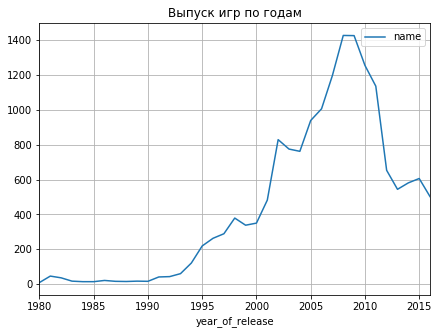

In [22]:
release_games_by_year.plot(figsize =(7,5), grid = True) # построение графика распределения выхода игр по годам
plt.title('Выпуск игр по годам')
plt.show()

И таблица и график показывают, что до 1995 г. выпуск игр был очень скромным, а дальше идет подъем и пик приходится на 2008-2009г. Развитие игровой индустрии непосредственно связано с развитием технологий и все большей доступностью игровых устройств (компьютеров, телефонов, приставок и т.д.). При этом на начальном этапе стоимость разработки игр была небольшой и не требовалась большая команда. Сам выпуск игры не требовал большого количества времени.  А вот спад после 2009г вполне возможно связан с тем, что игры стали более сложными в плане их разработки, построения, графики. Создание некоторых игр требует несколько лет разработки, большого штата сотрудников и немалого бюджета. Ко всему прочему, в списке указаны игры, которые устанавливаются на компьютеры, приставки или игровые консоли, а игр в которые играют из браузера без установки на устройство нет. Массовое распространение мобильных телефонов способствовало появлению мобильных игровых приложений; появилось направление создания игр для социальных сетей. Вполне возможно, что именно создание подобных игр стало причиной уменьшения количества игр на компьютерах и приставках в последние годы.

In [23]:
games['platform'].unique() # список уникальных значений названий платформ (чтобы убедится, что здесь нет бразеров)

array(['Wii', 'NES', 'GB', 'DS', 'X360', 'PS3', 'PS2', 'SNES', 'GBA',
       'PS4', '3DS', 'N64', 'PS', 'XB', 'PC', '2600', 'PSP', 'XOne',
       'WiiU', 'GC', 'GEN', 'DC', 'PSV', 'SAT', 'SCD', 'WS', 'NG', 'TG16',
       '3DO', 'GG', 'PCFX'], dtype=object)

Для выполнения поставленной задачи, нам не нужны все данные, потому что нам нужно учитывать тенденции, которые сложились в посление лет 10 или около того. Если не произойдет какой-то технический прорыв или что-то, что непосредственно повлияет на спрос на игры на указанных платформах, то общии тренд сохранится и количество выпускаемых игр будет падать. 

### Анализ распределения игр по платформам

Посмотрим как менялись продажи по платформам. Создадим сводную таблицу и построим столбчатую диаграмму, чтобы посмотреть распределение количества игр по платформам.

In [24]:
games_sales_by_platform = games.pivot_table(index = 'platform', values = 'total sales', aggfunc = 'sum').sort_values(by = 'total sales', ascending = False)


In [25]:
display(games_sales_by_platform)

,total sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58
PS4,314.14
GBA,312.88
PSP,289.53


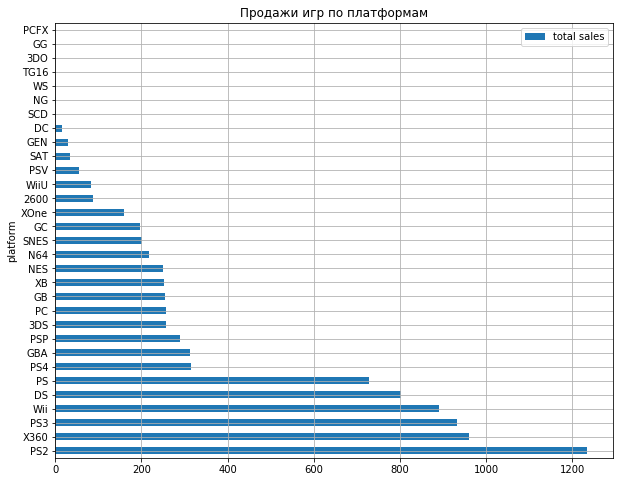

In [26]:
games_sales_by_platform.plot(kind = 'barh', figsize =(10, 8), grid = True)
plt.title('Продажи игр по платформам')
plt.show()

В лидерах у нас 6 платформ: PS2, X360, PS3, Wii, DS, PS. Построим распределение продаж по этим платформам по годам.

In [27]:
games_sales_by_platform_top = games_sales_by_platform[0:6] # сохраним в переменную данные по первым 6 платформам

In [28]:
display(games_sales_by_platform_top)

,total sales
platform,
PS2,1233.56
X360,961.24
PS3,931.34
Wii,891.18
DS,802.78
PS,727.58


Сделаем срез данных на основании индексов из сводной таблицы по лидерам продаж.

In [29]:
games_sales_by_top_platform_year = games.query('platform in @games_sales_by_platform_top.index') # срез данных из внешней переменной 

Создадим сводную таблицу по которой посчитаем среднее количество лет, которое существуют платформы.

In [30]:
platform_by_year = games_sales_by_top_platform_year.loc[:, ['year_of_release', 'platform']].drop_duplicates().pivot_table(index = 'platform', values = 'year_of_release', aggfunc = 'count')

In [31]:
platform_by_year.describe() # просмотр статистических данных

,year_of_release
count,6.000000
mean,11.166667
std,0.752773
min,10.000000
25%,11.000000
50%,11.000000
75%,11.750000
max,12.000000


В среднем платформа существует 11 лет. В качестве актуального примем период за 2014-2016 гг. включительно.

In [32]:
games_current_period = games.query('year_of_release > 2013 and year_of_release <= 2016') # срез данных в диапазоне между 2006 и 2016 г

In [33]:
display(games_current_period.head()) # просмотр первых 5 строк

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total sales
31,Call of Duty: Black Ops 3,PS4,2015,Shooter,6.03,5.86,0.36,2.38,NaN,NaN,unknown,14.63
42,Grand Theft Auto V,PS4,2014,Action,3.96,6.31,0.38,1.97,97.0,8.3,M,12.62
47,Pokemon Omega Ruby/Pokemon Alpha Sapphire,3DS,2014,Role-Playing,4.35,3.49,3.10,0.74,NaN,NaN,unknown,11.68
77,FIFA 16,PS4,2015,Sports,1.12,6.12,0.06,1.28,82.0,4.3,E,8.58
87,Star Wars Battlefront (2015),PS4,2015,Shooter,2.99,3.49,0.22,1.28,NaN,NaN,unknown,7.98


Построим столбчатую диаграмму и посмотрим распределение продаж по платформам.

In [34]:
games_current_period_group = games_current_period.groupby('platform')['total sales'].sum().sort_values(ascending = True)

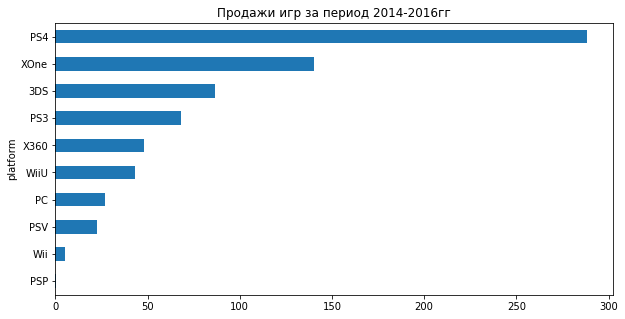

In [35]:
games_current_period_group.plot(kind = 'barh', figsize =(10, 5))
plt.title('Продажи игр за период 2014-2016гг')
plt.show()

По продажам лидируют PS4, XOne, 3DS, PS3, X360. Посмотрим как продажи по платформам распределяются по годам актуального периода.

In [36]:
platform_current_period = games_current_period.pivot_table(index = 'year_of_release', columns = 'platform', values ='total sales', aggfunc ='sum')
display(platform_current_period)

platform,3DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
year_of_release,,,,,,,,,,
2014,43.76,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14
2016,15.14,5.25,3.60,69.25,NaN,4.25,0.18,4.60,1.52,26.15


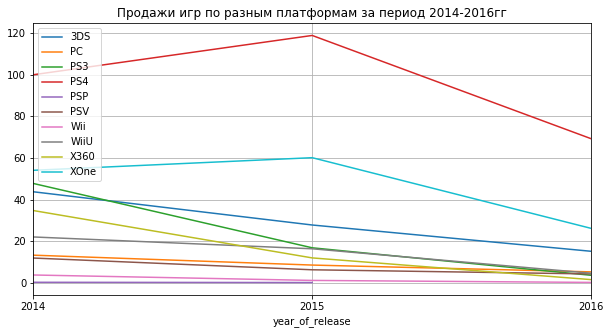

In [37]:
platform_current_period.plot(grid = True, figsize =(10, 5))
plt.legend(loc='upper left')
plt.xticks([2014,2015,2016])
plt.title('Продажи игр по разным платформам за период 2014-2016гг')
plt.show()

Брать в расчет платформы, на которых к 2016 г уже не выпускают игры нет смысла, потому что нам нужен план на 2017г. Удалим их из данных и оставим только тех у кого был выпуск новой продукции в 2016г.

In [38]:
platform_list= ['3DS', 'PC','PS3','PS4','PSV','Wii','WiiU','X360','XOne'] # список платформ у которых был выпуск в 2016г
actual_platforn = games_current_period.query('platform in @platform_list') # срез данных по актуальным платформам


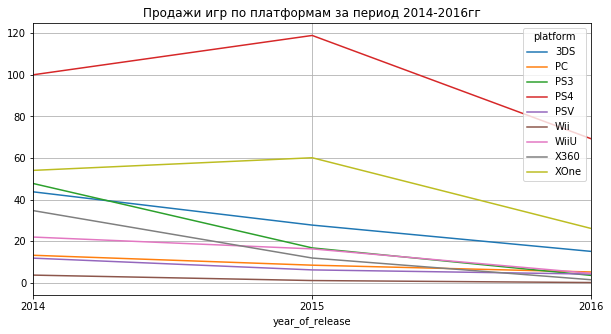

In [39]:
actual_platforn.pivot_table(index = 'year_of_release', columns = 'platform', values ='total sales', aggfunc ='sum').plot(grid = True, figsize =(10, 5))
plt.title('Продажи игр по платформам за период 2014-2016гг')
plt.xticks([2014,2015,2016])
plt.show()

Даже из 9 платформ, которые выпускали игры еще в 2016г, многие сильно снизили свои продажи, т.е они в самом конце жизненного цикла. Пожалуй только 3DS, PC, PS4, PSV, WiiU, XOne будут выпускать игры в 2017г в достаточном объеме. Но у всех идет тенденция к снижению объема выпуска.

Посмотрим по каким платформам самые большие продажи в 2016г, построив стобчатую диаграмму:

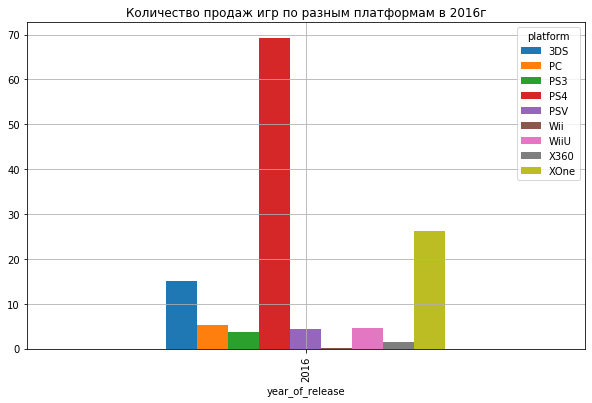

In [40]:
actual_platforn.loc[actual_platforn['year_of_release'] == 2016].pivot_table(index = 'year_of_release', columns = 'platform', values ='total sales', aggfunc ='sum').plot(kind = 'bar', grid = True, figsize =(10, 6))
plt.title('Количество продаж игр по разным платформам в 2016г')
plt.show()

Теперь можно выбрать тройку платформ, которые не смотря на снижение объемов продаж в 2017 г будут еще достаточно прибыльны. На первом месте PS4, на втором XOne, и на третьем 3DS.

Построим диаграмму размаха по глобальным продажам игр в разбивке по платформам.

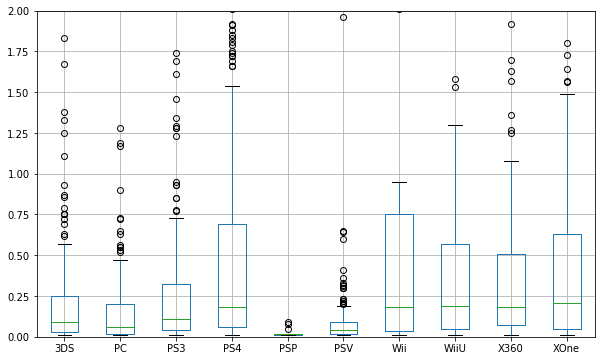

In [41]:
games_current_period.pivot_table(index = 'name', columns = 'platform', values ='total sales', aggfunc ='sum').boxplot(figsize =(10, 6))
plt.ylim(0,2)
plt.show()

In [42]:
display(games_current_period.pivot_table(index = 'name', columns = 'platform', values ='total sales', aggfunc ='sum').describe())

platform,3DS,PC,PS3,PS4,PSP,PSV,Wii,WiiU,X360,XOne
count,212.000000,151.000000,219.000000,376.000000,13.000000,295.000000,11.000000,73.000000,111.000000,228.000000
mean,0.408868,0.179139,0.311324,0.766356,0.027692,0.075932,0.460909,0.588767,0.434414,0.615614
std,1.188368,0.329359,0.633059,1.614969,0.027735,0.141591,0.625451,1.161467,0.628967,1.046513
min,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000
25%,0.030000,0.020000,0.040000,0.057500,0.010000,0.020000,0.035000,0.050000,0.070000,0.050000
50%,0.090000,0.060000,0.110000,0.185000,0.020000,0.040000,0.180000,0.190000,0.180000,0.205000
75%,0.250000,0.200000,0.325000,0.690000,0.020000,0.090000,0.755000,0.570000,0.505000,0.632500
max,11.680000,3.050000,5.270000,14.630000,0.090000,1.960000,2.010000,7.090000,4.280000,7.390000


На диаграмме видно, что в данных есть выбросы, т.е значения лежашие за пределами "усов" диаграммы размаха.

### Исследование влияния отзывов на продажи

Посмотрим как влияют на продажи внутри одной популярной платформы отзывы критиков и пользователей. Для примера возьмем платформу PS4, как популярную в последние годы и еще актуальную в 2016г. Можно было бы взять для анализа платформу X360, у которой за последние 11 лет (за период с 2006 по 2016 годы включительно) были самые большие продажи, но в 2016г продажи игр на этой  платформе сильно снизились и уже понятно, что в ближайший год, максимум два игры для этой платформы перестанут выпускать (ей на смену пришла платформа XOne). А нам нужно постоить план на 2017г и для этого возьмем самую перспективную платформу из имеющихся на 2016г.

Считаю необходимым для проверки зависимости продаж от отзывов, убрать из выборки те строки, где отзывы равны 0. Конечно, можно предположить, что продажи будут ниже, если стоит оценка 0. Но всегда есть вероятность, что нули возникли из-за некоректного внесения значений. Вот поэтому, чтобы исключить "спорные" строки, делаем анализ, только по тем данным, где значение отлично от нуля.

In [43]:
top_platform = games_current_period.loc[games_current_period['platform'] == 'PS4'] # с помощью логической индексации сохраняем в переменную строки соответствующие условию

Мы не будем создавать отдельные переменные для расчета коэффициента корреляции, а просто прямо передадим методу нужные срезы данных

In [44]:
top_platform.query('critic_score > 0')['total sales'].corr(top_platform.query('critic_score > 0')['critic_score']) # расчет корреляции между продажами и отзывами критиков

0.40266141068104083

Коэффициент корреляции Пирсона между продажами и оценками критиков средний. Прямая зависимость есть, но она умеренная.

In [45]:
top_platform.query('user_score>0')['total sales'].corr(top_platform.query('user_score>0')['user_score']) # расчет корреляции между продажами и отзывами пользователей

-0.040131589472697356

Коэффициент корреляции Пирсона между продажами и оценками пользователей близок к нулю. Наблюдаемся очень слабая, но отрицательная корреляция.

Построим диаграммы рассеивания:

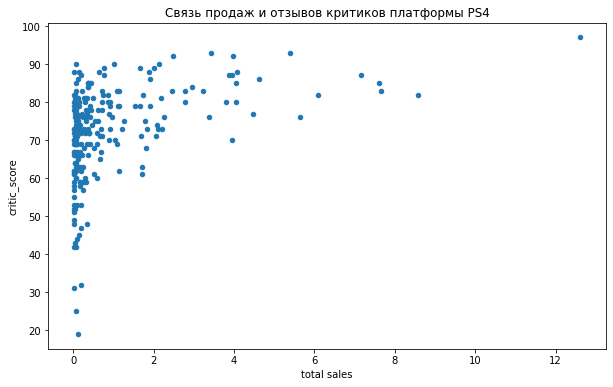

In [46]:
top_platform.query('critic_score > 0').plot(x='total sales', y = 'critic_score', kind = 'scatter', figsize =(10, 6)) # диаграмма рассеивания "продажи-отзывы критиков"
plt.title('Связь продаж и отзывов критиков платформы PS4')
plt.show()

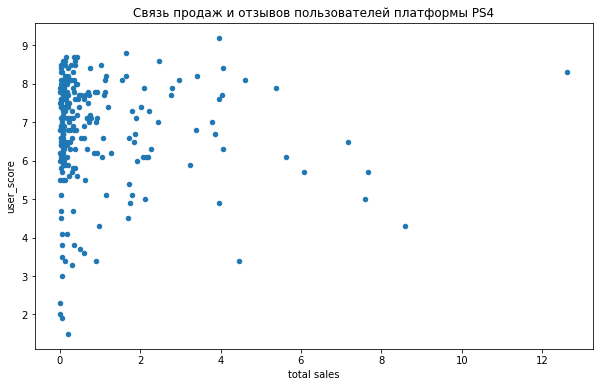

In [47]:
top_platform.query('user_score > 0').plot(x='total sales', y = 'user_score', kind = 'scatter', figsize =(10, 6)) # диаграмма рассеивания "продажи-отзывы пользователей"
plt.title('Связь продаж и отзывов пользователей платформы PS4')
plt.show()

Диаграмма рассеивания подтвердила вывод сделанный по коэффициенту корреляции. В паре "продажи- оценки критиков", данные более сконцентрированы и просматривается зависимость, хотя и не очень сильная. В паре "продажи- оценки пользователей" точки рассеяны достаточно произвольно без какого-либо общего тренда.

Теперь посмотрим общие тенденции по всем остальным платформам, которые были у нас в актуальном периоде. Из данных исключим строки с нулевым значением отзывов и строки с платформой PS4 - ее мы уже посмотрели и было бы интересно посмотреть данные без ее влияния.

In [48]:
games_current_period.query('critic_score >0 and platform != "PS4"')['total sales'].corr(games_current_period.query('critic_score>0 and platform != "PS4"')['critic_score']) 
# расчет корреляции между продажами и отзывами критиков

0.30947400260011515

In [49]:
games_current_period.query('user_score > 0 and platform != "PS4"')['total sales'].corr(games_current_period.query('user_score > 0 and platform != "PS4"')['user_score'])
# расчет корреляции между продажами и отзывами пользователей

-0.02347818723797556

Коэффициент корреляции в паре "продажи - оценки критиков" ниже, чем для платформы PS4. Корреляция положительная, связь достаточно слабая. А в паре "продажи - оценки пользователей", корреляция практически отсустствует, и она также отрицательная, как у PS4.

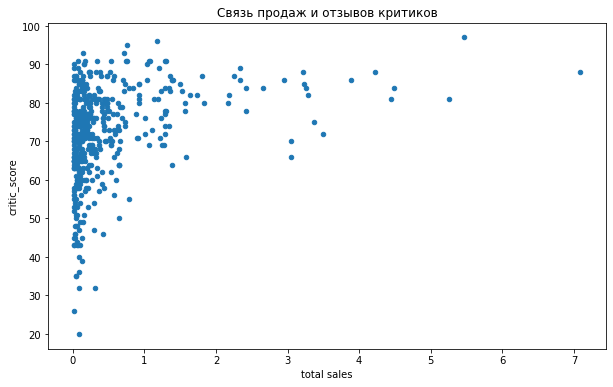

In [50]:
games_current_period.query('critic_score > 0 and platform != "PS4"').plot(x='total sales', y = 'critic_score', kind = 'scatter', figsize =(10, 6)) # диаграмма рассеивания "продажи-отзывы критиков
plt.title('Связь продаж и отзывов критиков')
plt.show()

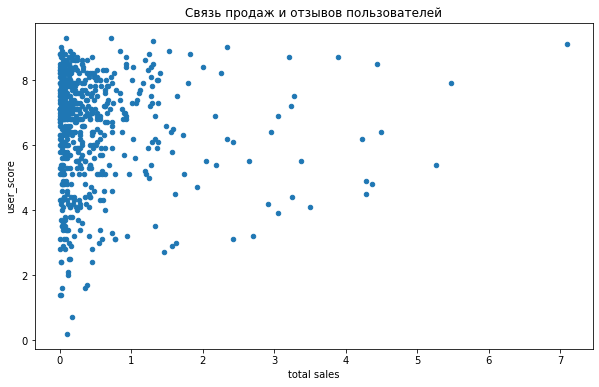

In [51]:
games_current_period.query('user_score > 0 and platform != "PS4"').plot(x='total sales', y = 'user_score', kind = 'scatter', figsize =(10, 6)) # диаграмма рассеивания "продажи-отзывы пользователей
plt.title('Связь продаж и отзывов пользователей')
plt.show()

Диаграмма рассеивания для пары "продажи-оценки пользователей"по прежнему достаточно хаотична.

### Анализ распределения игр по жанрам

Посмотрим на распределение игр по жанрам за актуальный период (напомню актуальным у нас принят период 2014-2016гг включительно)

Создадим сводную таблицу и построим столбчатую диаграмму. В столбцах считается количество игр выпущенных на каждой конкретной платформе.

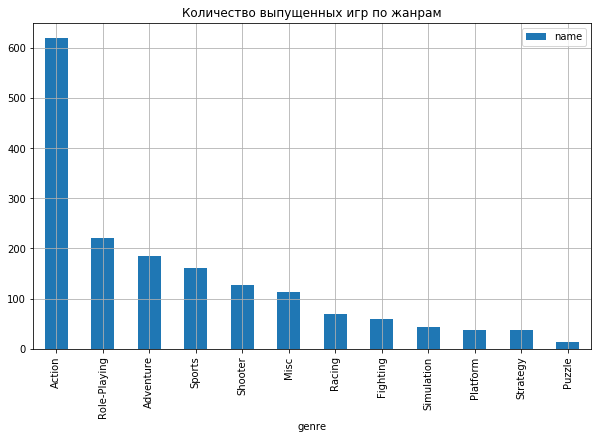

In [52]:
games_current_period.pivot_table(index = 'genre', values ='name', aggfunc ='count').sort_values(by='name', ascending = False).plot(kind = 'bar', grid = True, figsize =(10, 6))
plt.title('Количество выпущенных игр по жанрам')
plt.show()

Наибольшее количество игр выпускается в жанре экшен, а меньше всего в жанре платформер.

Теперь посмотрим продажи по жанрам. Игры какого жанра продаются лучше. Для сравнения посмотрим среднее по продажам и медиану.

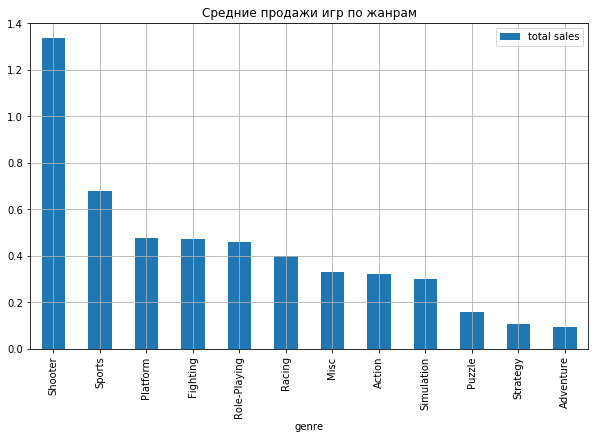

In [53]:
games_current_period.pivot_table(index = 'genre', values ='total sales', aggfunc ='mean').sort_values(by='total sales', ascending = False).plot(kind = 'bar', grid = True, figsize =(10, 6))
plt.title('Средние продажи игр по жанрам')
plt.show()

Не смотря на то, что игр в жанре экшен выпушено больше всего, в лидеры по продажам попадает шестерка жанров: Shooter, Sports, Platform, Fighting, Role-Playing. 

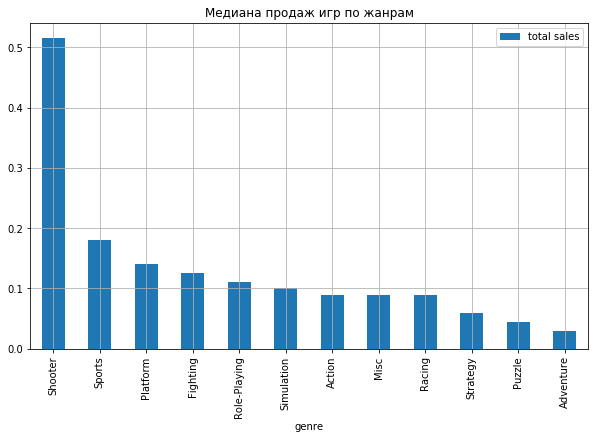

In [54]:
games_current_period.pivot_table(index = 'genre', values ='total sales', aggfunc ='median').sort_values(by='total sales', ascending = False).plot(kind = 'bar', grid = True, figsize =(10, 6))
plt.title('Медиана продаж игр по жанрам')
plt.show()

Интересно, что и при расчете медианы и при расчете среднего, пятерка лидиров у нас одинаковая. Далее идут разные вариации. 

**Вывод**

В данном разделе мы посмотрели распределение игр по годам, по платформам и жанрам. Выявили какие платформы и жанры наиболее популярны.

Мы обнаружили, что платформа живет в среднем 11 лет, а потом ей на смену приходит другая более удобная, технологичная (как говорят "продвинутая"). В качестве актуального приняли период с 2014 по 2016гг. включительно.

При анализе, какие же платформы самые популярные мы выявили список, но оказалось что для части из них, к 2016г уже перестали выпускать игры или их выпуск минимален. Помня о том, что нам нужно построить план на 2017г., мы приняли целесообразным посмотреть только те платформы, которые не закрылись к 2016г. И мы получили тройку лидеров по продажам: PS4, XOne, 3DS.

Далее мы посмотрели насколько отзывы критиков и пользователей влияют на продажи на примере одной популярной платформы, а затем все остальные платформы. Оказалось, что для платформы PS4 связь между продажами и отзывами критиков существует и она средняя, а связи между отзывами пользователей и продажами игр на этой платформе практически нет, более того она отрицательная. Данные по корреляции между продажами и отзывами по всем остальным платформам немного отличаются, от данных по PS4 - корреляция между продажами и отзывами критиков более слабая, а корреляция между отзывами пользователей и продажами, практически отсутствует как и для PS4.

Мы также посмотрели какие жанры наиболее популярны. В лидерах продаж у нас оказались: Shooter, Sports, Platform, Fighting, Role-Playing. При этом наибольшее количество игр выпускается в жанре Action, но если смотреть по медиане, то этот жанр только седьмой в списке.

## Портрет пользователя каждого жанра

В этом разделе мы посмотрим какие жанры характерны, для того или иного региона, определим самые популярные в регионах платформы и посмотрим влияет ли рейтинг ESRB на продажи.

### Анализ популярных платформ по регионам

Поскольку нам нужно построить план на 2017г, то для анализа популярных платформ посмотрим данные за 2016г

In [55]:
platform_region = games_current_period.query('year_of_release == 2016') 


Для каждого региона построим столбчатую диаграмму, а затем выделим пятерку лидирующих по продажам платформ. Начнем с Северной Америки:

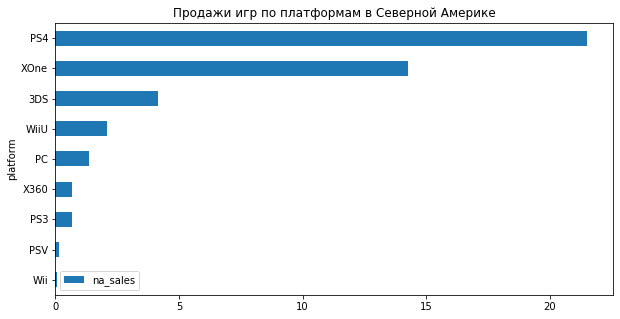

In [56]:
platform_region.pivot_table(index = 'platform', values = 'na_sales', aggfunc ='sum').sort_values(by = 'na_sales', ascending = True).plot(kind = 'barh', figsize =(10, 5))
plt.title('Продажи игр по платформам в Северной Америке')
plt.show()

In [57]:
na_sales_platform_top = platform_region.pivot_table(index = 'platform', values = 'na_sales', aggfunc ='sum').sort_values(by = 'na_sales', ascending = False)[0:5]
display(na_sales_platform_top)

,na_sales
platform,
PS4,21.49
XOne,14.27
3DS,4.14
WiiU,2.10
PC,1.36


Как и ранее в анализе без разбивки по регионам, лидирует PS4. За ней идут: XOne, 3DS, WiiU, PC. Далее посмотрим Европу:

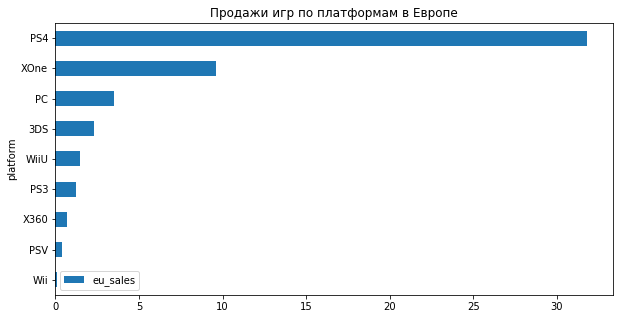

In [58]:
platform_region.pivot_table(index = 'platform', values = 'eu_sales', aggfunc ='sum').sort_values(by = 'eu_sales', ascending = True).plot(kind = 'barh', figsize =(10, 5))
plt.title('Продажи игр по платформам в Европе')
plt.show()

In [59]:
eu_sales_platform_top = platform_region.pivot_table(index = 'platform', values = 'eu_sales', aggfunc ='sum').sort_values(by = 'eu_sales', ascending = False)[0:5]
display(eu_sales_platform_top)

,eu_sales
platform,
PS4,31.78
XOne,9.63
PC,3.53
3DS,2.33
WiiU,1.48


И здесь лидирует PS4. За ним идет XOne, как и в Северной Америке, а дальше три платформы повторяются как в Америке, но у них другое распределение мест по популярности. Что же у нас в Японии?

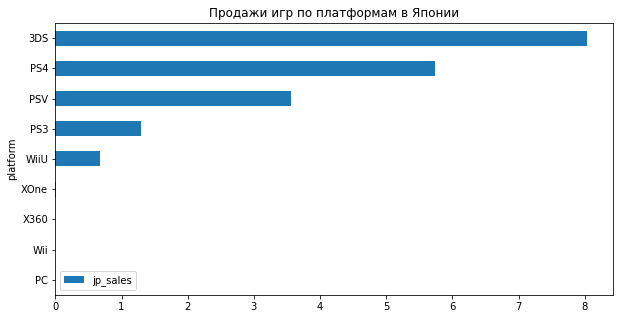

In [60]:
platform_region.pivot_table(index = 'platform', values = 'jp_sales', aggfunc ='sum').sort_values(by = 'jp_sales', ascending = True).plot(kind = 'barh', figsize =(10, 5))
plt.title('Продажи игр по платформам в Японии')
plt.show()

In [61]:
jp_sales_platform_top = platform_region.pivot_table(index = 'platform', values = 'jp_sales', aggfunc ='sum').sort_values(by = 'jp_sales', ascending = False)[0:5]
display(jp_sales_platform_top)

,jp_sales
platform,
3DS,8.03
PS4,5.74
PSV,3.56
PS3,1.30
WiiU,0.67


Здесь тоже есть PS4, но он уже не на первом месте, а XOne и PC вообще нет, но появились платформы PSV и PS3. И напоследок посмотрим "другие" страны:

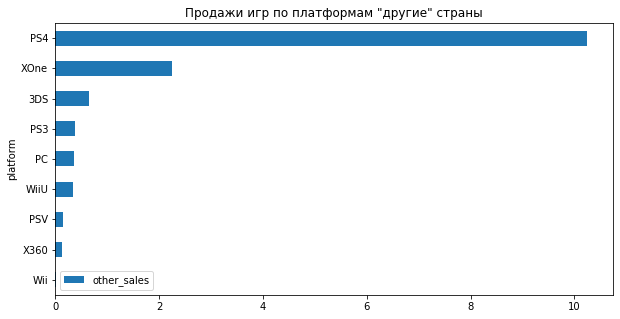

In [62]:
platform_region.pivot_table(index = 'platform', values = 'other_sales', aggfunc ='sum').sort_values(by = 'other_sales', ascending = True).plot(kind = 'barh', figsize =(10, 5))
plt.title('Продажи игр по платформам "другие" страны')
plt.show()

In [63]:
other_sales_platform_top = platform_region.pivot_table(index = 'platform', values = 'other_sales', aggfunc ='sum').sort_values(by = 'other_sales', ascending = False)[0:5]
display(other_sales_platform_top)

,other_sales
platform,
PS4,10.24
XOne,2.24
3DS,0.64
PS3,0.37
PC,0.36


Здесь распределение мест лидеров, похоже на Америку, с той лишь разницей, что вместо WiiU, стоит PS3.

Сделаем сводную таблицу наших лидеров, чтобы посчитать доли продаж по каждому региону. Сделаем мы это методом join() с дополнительным параметром how = 'outer', чтобы в сводую таблицу попали данные по лидерам всех регионов. В полученной сводной таблице пропуски заменим на 0.

In [64]:
top_platform_region = na_sales_platform_top.join((eu_sales_platform_top, jp_sales_platform_top, other_sales_platform_top), how = 'outer')
top_platform_region = top_platform_region.fillna(0)
display(top_platform_region)

,na_sales,eu_sales,jp_sales,other_sales
PS4,21.49,31.78,5.74,10.24
XOne,14.27,9.63,0.00,2.24
3DS,4.14,2.33,8.03,0.64
WiiU,2.10,1.48,0.67,0.00
PC,1.36,3.53,0.00,0.36
PSV,0.00,0.00,3.56,0.00
PS3,0.00,0.00,1.30,0.37


Посчитаем суммарные продажи по всем регионам:

In [65]:
top_platform_region['total'] = top_platform_region['na_sales'] + top_platform_region['eu_sales'] + top_platform_region['jp_sales'] + top_platform_region['other_sales']

display(top_platform_region)

,na_sales,eu_sales,jp_sales,other_sales,total
PS4,21.49,31.78,5.74,10.24,69.25
XOne,14.27,9.63,0.00,2.24,26.14
3DS,4.14,2.33,8.03,0.64,15.14
WiiU,2.10,1.48,0.67,0.00,4.25
PC,1.36,3.53,0.00,0.36,5.25
PSV,0.00,0.00,3.56,0.00,3.56
PS3,0.00,0.00,1.30,0.37,1.67


Напишем функцию, которая пройдется по всем столбцам с указанием региона и заменит сумму продаж, на долю продаж региона в общей сумме.

In [66]:
def func(row):
    row.na_sales = round(row.na_sales / row.total,2)
    row.eu_sales = round(row.eu_sales / row.total,2)
    row.jp_sales = round(row.jp_sales / row.total,2)
    row.other_sales = round(row.other_sales / row.total,2)
    return row
top_platform_region_delta = top_platform_region.apply(func, axis =1)
display(top_platform_region_delta)

,na_sales,eu_sales,jp_sales,other_sales,total
PS4,0.31,0.46,0.08,0.15,69.25
XOne,0.55,0.37,0.00,0.09,26.14
3DS,0.27,0.15,0.53,0.04,15.14
WiiU,0.49,0.35,0.16,0.00,4.25
PC,0.26,0.67,0.00,0.07,5.25
PSV,0.00,0.00,1.00,0.00,3.56
PS3,0.00,0.00,0.78,0.22,1.67


Построим диаграммы для визуализации долей продаж по каждой из популярных платформ. По платформе PSV диаграмму рисовать не будем, потому что эта платформа есть только в Японии.

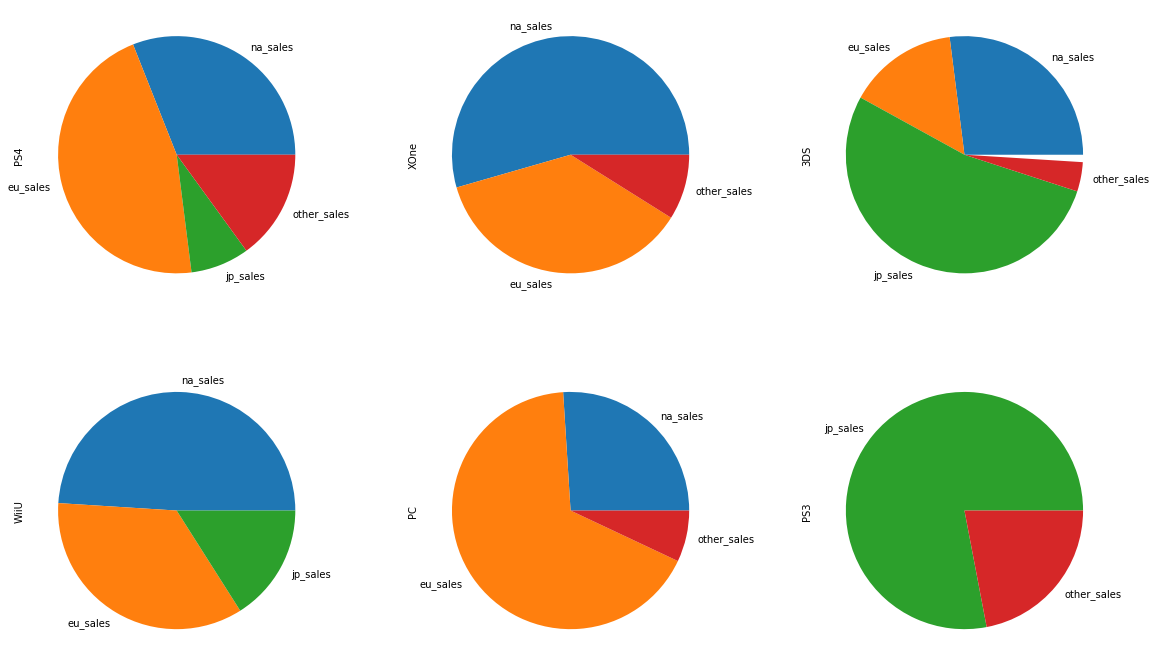

In [67]:
fig, axis = plt.subplots(2,3, figsize = (20,12))
top_platform_region_delta.loc['PS4', ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].plot(kind = 'pie', ax=axis[0,0])
top_platform_region_delta.loc['XOne', ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].plot(kind = 'pie', ax=axis[0,1])
top_platform_region_delta.loc['3DS', ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].plot(kind = 'pie', ax=axis[0,2])
top_platform_region_delta.loc['WiiU', ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].plot(kind = 'pie', ax=axis[1,0])
top_platform_region_delta.loc['PC', ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].plot(kind = 'pie', ax=axis[1,1])
top_platform_region_delta.loc['PS3', ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].plot(kind = 'pie', ax=axis[1,2])
plt.show()

По диаграммам видно, что игры на PS4 и PC ,больше всего продаются в Европе. А на Северную Америку приходится большая часть продаж игр на XOne и WiiU. Япония лидирует по доли продаж на платформах 3DS и PS3.

### Анализ популярных жанров по регионам

Для анализа жанров возьмем весь актуальный период и посмотрим в каком регионе, что предпочитают больше.

Опять построим столбчатые диаграммы и выберем пятерку жанров с самыми большими продажами в каждом регионе. Начнем с Северной Америки:

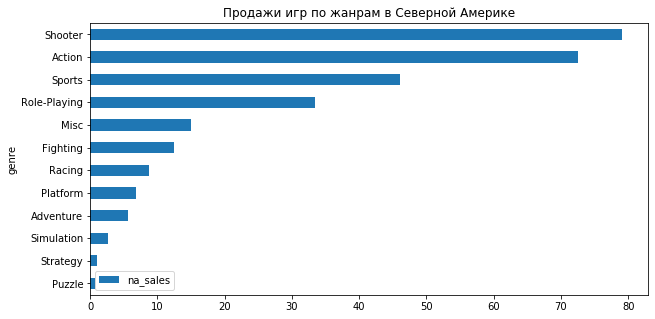

In [68]:
games_current_period.pivot_table(index = 'genre', values = 'na_sales', aggfunc ='sum').sort_values(by = 'na_sales', ascending = True).plot(kind = 'barh', figsize =(10, 5))
plt.title('Продажи игр по жанрам в Северной Америке')
plt.show()

In [69]:
na_sales_genre_top = games_current_period.pivot_table(index = 'genre', values = 'na_sales', aggfunc ='sum').sort_values(by = 'na_sales', ascending = False)[0:5]
display(na_sales_genre_top)

,na_sales
genre,
Shooter,79.02
Action,72.53
Sports,46.13
Role-Playing,33.47
Misc,15.05


Shooter, Action, Sports, Role-Playing, Misc - это наши лидеры в регионе Северная Америка. 

Далее посмотрим Европу.

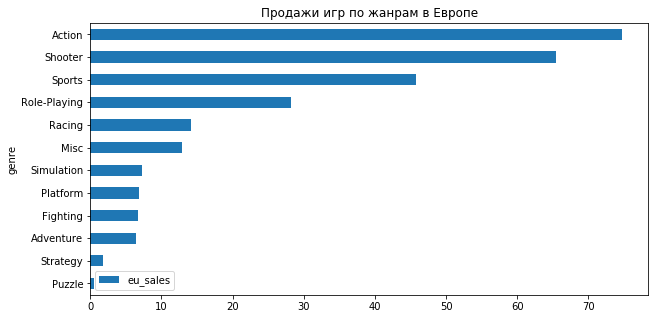

In [70]:
games_current_period.pivot_table(index = 'genre', values = 'eu_sales', aggfunc ='sum').sort_values(by = 'eu_sales', ascending = True).plot(kind = 'barh', figsize =(10, 5))
plt.title('Продажи игр по жанрам в Европе')
plt.show()

In [71]:
eu_sales_genre_top = games_current_period.pivot_table(index = 'genre', values = 'eu_sales', aggfunc ='sum').sort_values(by = 'eu_sales', ascending = False)[0:5]
display(eu_sales_genre_top)

,eu_sales
genre,
Action,74.68
Shooter,65.52
Sports,45.73
Role-Playing,28.17
Racing,14.13


Список лидеров повторяется, за исключением, того что Action вырвался на первое место и на последнем теперь там Racing вместо Misc. Что же получится в Японии?

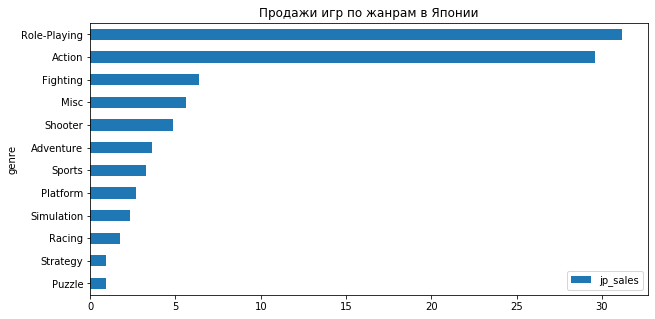

In [72]:
games_current_period.pivot_table(index = 'genre', values = 'jp_sales', aggfunc ='sum').sort_values(by = 'jp_sales', ascending = True).plot(kind = 'barh', figsize =(10, 5))
plt.title('Продажи игр по жанрам в Японии')
plt.show()

In [73]:
jp_sales_genre_top = games_current_period.pivot_table(index = 'genre', values = 'jp_sales', aggfunc ='sum').sort_values(by = 'jp_sales', ascending = False)[0:5]
display(jp_sales_genre_top)

,jp_sales
genre,
Role-Playing,31.16
Action,29.58
Fighting,6.37
Misc,5.61
Shooter,4.87


Как и с платформами, в Японии немного другие вкусы. Они схожи, но Role-Playing, который в Америке был на 4-м месте, в Японии, наоборот на первом. В пятерку лидеров вошел жанр Fighting, который ни в Америке, ни в Европе не пользуется большим спросом.

Посмотрим пятерку лидеров для "других" стран:

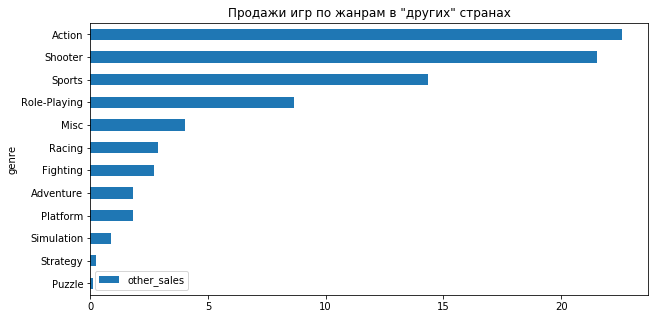

In [74]:
games_current_period.pivot_table(index = 'genre', values = 'other_sales', aggfunc ='sum').sort_values(by = 'other_sales', ascending = True).plot(kind = 'barh', figsize =(10, 5))
plt.title('Продажи игр по жанрам в "других" странах')
plt.show()

In [75]:
other_sales_genre_top = games_current_period.pivot_table(index = 'genre', values = 'other_sales', aggfunc ='sum').sort_values(by = 'other_sales', ascending = False)[0:5]
display(other_sales_genre_top)

,other_sales
genre,
Action,22.57
Shooter,21.53
Sports,14.36
Role-Playing,8.64
Misc,4.03


Здесь у пользователей те же предпочтения, что и в Северной Америке: Action, Sports, Shooter, Misc, Role-Playing

Сделаем сводную таблицу их всех наших лидеров:

In [76]:
top_genre_region = na_sales_genre_top.join((eu_sales_genre_top, jp_sales_genre_top, other_sales_genre_top), how = 'outer')
top_genre_region = top_genre_region.fillna(0)
display(top_genre_region)

,na_sales,eu_sales,jp_sales,other_sales
Shooter,79.02,65.52,4.87,21.53
Action,72.53,74.68,29.58,22.57
Sports,46.13,45.73,0.00,14.36
Role-Playing,33.47,28.17,31.16,8.64
Misc,15.05,0.00,5.61,4.03
Racing,0.00,14.13,0.00,0.00
Fighting,0.00,0.00,6.37,0.00


Посчитаем сумму продаж:

In [77]:
top_genre_region['total_sales_genre'] = top_genre_region['na_sales'] + top_genre_region['eu_sales'] + top_genre_region['jp_sales'] + top_genre_region['other_sales']

display(top_genre_region)

,na_sales,eu_sales,jp_sales,other_sales,total_sales_genre
Shooter,79.02,65.52,4.87,21.53,170.94
Action,72.53,74.68,29.58,22.57,199.36
Sports,46.13,45.73,0.00,14.36,106.22
Role-Playing,33.47,28.17,31.16,8.64,101.44
Misc,15.05,0.00,5.61,4.03,24.69
Racing,0.00,14.13,0.00,0.00,14.13
Fighting,0.00,0.00,6.37,0.00,6.37


Создадим функцию для замены значений продаж по столбцам с указанием регионов, на долю продаж:

In [78]:
def func(row):
    row.na_sales = round(row.na_sales / row.total_sales_genre,2)
    row.eu_sales = round(row.eu_sales / row.total_sales_genre,2)
    row.jp_sales = round(row.jp_sales / row.total_sales_genre,2)
    row.other_sales = round(row.other_sales / row.total_sales_genre,2)
    return row
top_genre_region_delta = top_genre_region.apply(func, axis =1)
display(top_genre_region_delta)

,na_sales,eu_sales,jp_sales,other_sales,total_sales_genre
Shooter,0.46,0.38,0.03,0.13,170.94
Action,0.36,0.37,0.15,0.11,199.36
Sports,0.43,0.43,0.00,0.14,106.22
Role-Playing,0.33,0.28,0.31,0.09,101.44
Misc,0.61,0.00,0.23,0.16,24.69
Racing,0.00,1.00,0.00,0.00,14.13
Fighting,0.00,0.00,1.00,0.00,6.37


Сделаем круговые диаграммы по каждому из жанров-лидеров, показывающие распределение долей продаж по регионам. Диаграммы для Racing и Platform стоить не будем, так как эти жанры характерны только для одного региона: Racing -для Европы, а Platform - для Японии.

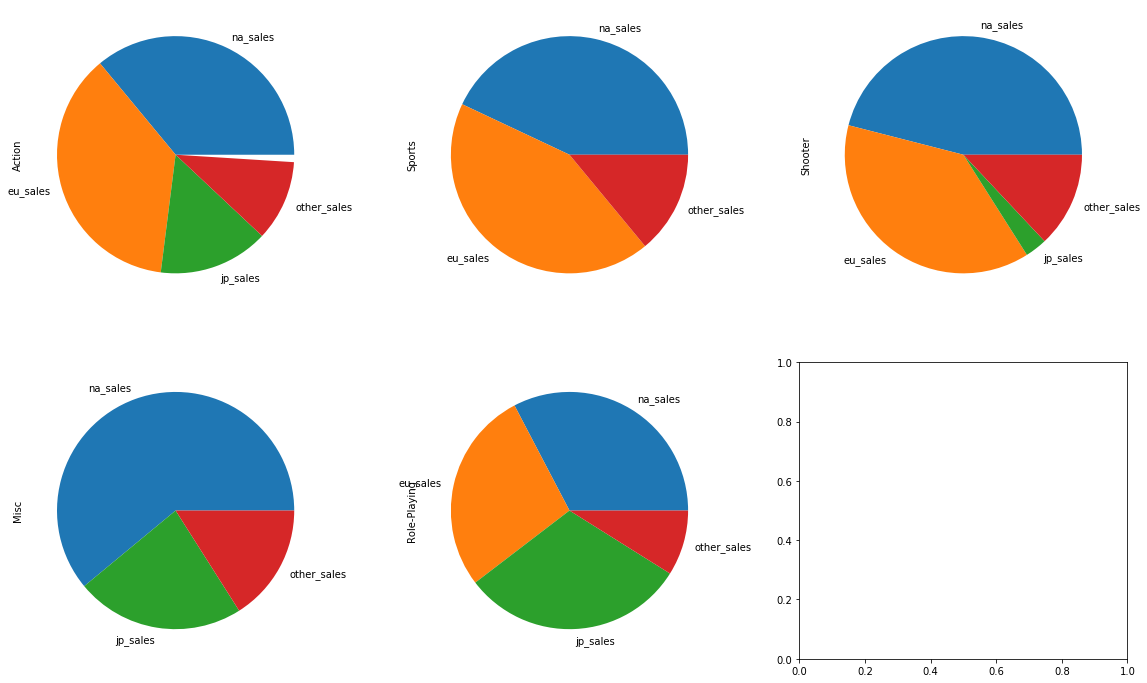

In [79]:
fig, axis = plt.subplots(2,3, figsize = (20,12))
top_genre_region_delta.loc['Action', ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].plot(kind = 'pie', ax=axis[0,0])
top_genre_region_delta.loc['Sports', ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].plot(kind = 'pie', ax=axis[0,1])
top_genre_region_delta.loc['Shooter', ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].plot(kind = 'pie', ax=axis[0,2])
top_genre_region_delta.loc['Misc', ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].plot(kind = 'pie', ax=axis[1,0])
top_genre_region_delta.loc['Role-Playing', ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']].plot(kind = 'pie', ax=axis[1,1])
plt.show()

В Северной Америке и Европе доля продаж игрв жанре Sports. Игры в жанре Action тоже примерно одинаково продаются. Role-Playing в Америке, Европе и Японии примерно одинаковые.

### Анализ влияния рейтинга ESRB на продажи по регионам

В этом разделе посмотрим с какой возрастной категорией предпочитают игры пользователи разных регионов.

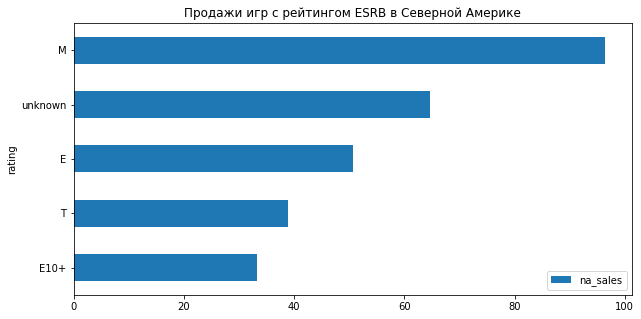

In [80]:
games_current_period.pivot_table(index = 'rating', values = 'na_sales', aggfunc ='sum').sort_values(by = 'na_sales', ascending = True).plot(kind = 'barh', figsize =(10, 5))
plt.title('Продажи игр с рейтингом ESRB в Северной Америке')
plt.show()

Поскольку рейтинг ESRB, создавался прежде всего для рецензирования игр в США и Канаде, то понятно почему, большая часть игр имеет указанный рейтинг. Хотя есть некоторое количество игр не имеющих рейтинга, но как говорилось ранее рейтинг рекомендуем, но не обязателен. В основном в Северной Америке предпочитают игры с рейтингом М - для взрослых (от 17 лет). Затем идут игры без рейтинга. А на третьем месте, наоборот игры с рейтингом E, т.е для всех, включая детей от 6 лет - для взрослых (от 17 лет). Далее идет рейтинг Т - для подростков от 13 лет. Затем рейтинг Е+10 - для летей от 10 лет.

Далее посмотрим Европу:

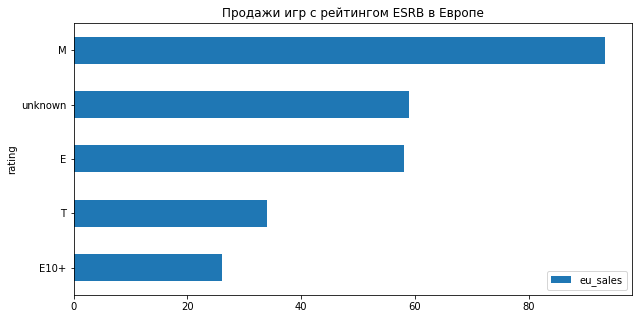

In [81]:
games_current_period.pivot_table(index = 'rating', values = 'eu_sales', aggfunc ='sum').sort_values(by = 'eu_sales', ascending = True).plot(kind = 'barh', figsize =(10, 5))
plt.title('Продажи игр с рейтингом ESRB в Европе')
plt.show()

И вновь на первом месте по продажам игры для взрослых. Дальнейшее распределение очень похоже на распределение в Северной Америке. Игр без рейтинга достаточно много, это скорее всего связано с тем, что в Европе действуют свои рейтинги. PEGI - это европейский аналог ESRB.

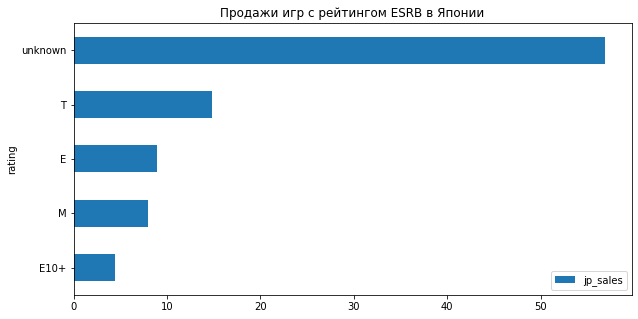

In [82]:
games_current_period.pivot_table(index = 'rating', values = 'jp_sales', aggfunc ='sum').sort_values(by = 'jp_sales', ascending = True).plot(kind = 'barh', figsize =(10, 5))
plt.title('Продажи игр с рейтингом ESRB в Японии')
plt.show()

Для игр продаваемых в Японии характерно отсутствие рейтинга ESRB. Есть определенная доля игр с рейтингом Е и Т. Не много игр для взрослых и детей от 10 лет. Кстати в Японии тоже есть аналог ESRB - это CERO. А теперь посмотрим "другие" страны:

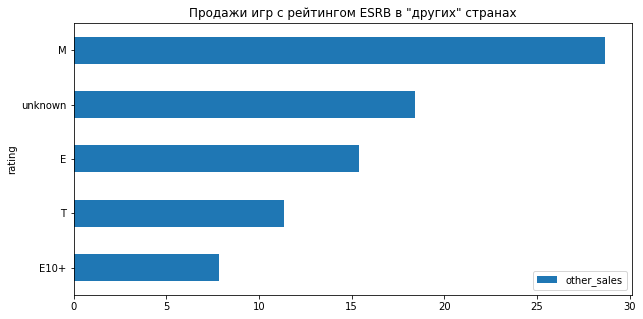

In [83]:
games_current_period.pivot_table(index = 'rating', values = 'other_sales', aggfunc ='sum').sort_values(by = 'other_sales', ascending = True).plot(kind = 'barh', figsize =(10, 5))
plt.title('Продажи игр с рейтингом ESRB в "других" странах')
plt.show()

По другим странам картина очень напоминает Европу и Америку. 

**Вывод**

В этом разделе мы посмотрели какие платформы предпочитают пользователи разных регионов, какие жанры им нравятся и игры из какой возрастной категории они предпочитают.

Так для Северной Америки характерны игры в жанрах Action, Sports, Shooter, Misc, Role-Playing, на платформах PS4. XOne, 3DS, WiiU, PC. Большая часть склоняется к играм для всех, включая детей от 6 лет или наоборот, к играм для взрослых. Есть некоторая доля игр без рейтинга, что говорит о том, что рейтинга может и не быть, но допускаю мысль об ошибке в данных, которую без посторонней помощи мы исправить не сможем.

Жители Европы достаточно близки к североамериканцам. Они предпочитают игры в жанрах Action, Sports, Shooter, Misc, Racing на платформах PS4, XOne, PC, 3DS, WiiU. Большая часть игр имеет рейтинг Е (для всех и детей от 6 дет). Игры для взрослых тут тоже очень хорошо продаются. Игр без рейтинга ESRB достаточно много, но скорее всего, это объясняется тем, что в Европе своя рейтинговая система. 	

Пользователи из Японии- это люди с достаточно сильно отличающимися от европейцев менталитетом и культурой, что не может не сказаться на их предпочтениях. Они выбирают игры в жанрах Role-Playing, Action, Misc, Sports, Platform на платформах 3DS, PS4, PSV, PS3, WiiU. У них своя система рейтингов и поэтому у них мало игр с ESRB. Поскольку подавляющее большенство игр для Японии в нашей выборке без рейтинга, то сложно с уверенностью сказать, что они любят больше: игры для всех или игры для взрослых, или вообще что-то третье.

Другие страны по своим предпочтениям ближе к Америке и Европе, чем к Японии. Они любят игры в жанрах Action, Sports, Shooter, Misc, Role-Playing, на платформах PS4, XOne, 3DS, PS3, PC, соответствующие рейтингам Е (для всех) и М (для взрослых).	

## Проверка гипотез

### Гипотеза о равенстве пользовательских рейтингов  платформ XboxOne и PC

Поскольку в нулевой гипотезе принято указывать равенство показателей, то в качестве нулевой у нас будет как раз предложенная гипотеза о равенстве пользовательских рейтингов платформ XboxOne и PC. А в качестве альтернативной гипотезы, будет неравенство пользовательских рейтингов этих платформ.

Для начала сделаем две выборки: одну по платформе XboxOne, а вторую по PC. Строки с нулевым рейтингом в анализе учавствовать не будут.

In [84]:
x_one = games_current_period.query('platform == "XOne" and user_score > 0')
x_one = x_one ['user_score']
pc = games_current_period.query('platform == "PC" and user_score > 0')
pc = pc['user_score']

Зададим пороговое значение статистической значимости на уровне 5%. Добавим дополнительный параметр equal_var = False, т.к. мы не можем сказать, что выборки равны и схожи по параметрам, поэтому пусть дисперсия считается для каждой выборки отдельно.

In [85]:
alpha = .05
results = st.ttest_ind(x_one, pc, equal_var = False)
display('р-значение', results.pvalue)

if results.pvalue < alpha:
    display("Отвергаем нулевую гипотезу")
else:
    display("Не получилось отвергнуть нулевую гипотезу") 

'р-значение'

0.11601398086668827

'Не получилось отвергнуть нулевую гипотезу'

Полученая статистическая значимость выше порогового значения, а это значит, что вероятнее всего, что пользовательские рейтинги платформ XboxOne и PC равны. И мы делаем вывод о том, что альтернативная гипотеза в этом случае получает меньше шансов оказаться верной.

In [86]:
display(x_one.mean())

6.594545454545456

In [87]:
display(pc.mean())

6.298360655737705

Действительно средние пользовательских рейтингов платформ XboxOne и PC очень близки.

### Гипотеза о неравенстве пользовательских рейтингов жанров Action и Sports

В качестве нулевой гипотезы примем равенство пользовательских рейтингов жанров Action и Sports. А в качестве альтернативной - гипотезу о их неравенстве.

Для начала сделаем две выборки: одну по жанру Action, а вторую по Sports. Строки с нулевым рейтингом в анализе учавствовать не будут.

In [88]:
action = games_current_period.query('genre == "Action" and user_score > 0')
action = action ['user_score']
sports = games_current_period.query('genre == "Sports" and user_score > 0')
sports = sports['user_score']

Зададим пороговое значение статистической значимости на уровне 5%. Добавим дополнительный параметр equal_var = False - причины те же, что и при проверки первой гипотезы.

In [89]:
alpha = .05
results = st.ttest_ind(action, sports, equal_var = False)
display('р-значение', results.pvalue)

if results.pvalue < alpha:
    display("Отвергаем нулевую гипотезу")
else:
    display("Не получилось отвергнуть нулевую гипотезу") 

'р-значение'

1.1825550382644557e-14

'Отвергаем нулевую гипотезу'

Значение p-value меньше порогового значения статистической значимости. Подтверждение нулевой гипотезы маловероятно. Гипотеза о неравенстве пользовательских рейтингов жанров Action и Sports вероятнее всего верна.

In [90]:
display(action.mean())


6.760606060606061

In [91]:
display(sports.mean())

5.2251968503937

Тут подтверждается неравенство средних пользовательских рейтингов жанров Action и Sports.

**Вывод**


Мы рассмотрели две гипотезы: одна о равенстве пользовательских рейтингов платформ XboxOne и PC, а вторая о неравенстве пользовательских рейтингов жанров Action и Sports. В качестве нулевых гипотез, мы приняли равенство рейтингов, а в качестве альтернативных неравенство рейтингов пользьзователей.

Расчеты не подтвердили нулевую гипотезу во втором случае, а в первом вероятность подтверждения нулевой гипотезы достаточно высока. Помним, что никакие эксперементально полученные данные никогда не подтвердят какую-либо гипотезу. Поэтому в нашем случае мы скажем, что данные взятые для проверки гипотез, в первом случае не противоречат гипотезе о равенстве пользовательских рейтингов, а во втором не противорячат гипотезе о неравенстве рейтингов. 

## Общий вывод

В данной работе мы проводили исследования рынка компьютерных игр.

В первом разделе мы посмотрели общие данные о файле и обнаружили определенные недостатки в данных: пропуски, неверный тип и некорректное названия столбцов в таблице. Во втором разделе мы эти неточности исправили. А также добавили дополнительные данные, такие как суммарные продажи по каждой позиции. Во втором разделе, мы также обнаружили аббревиатуру 'tbd' в отзывах пользователей. Эта аббревиатура означает - "не определен". Эти строки мы оставили незаполненными.

В третьей части проекта мы провели анализ прожаж игр по платформам и по жанрам по суммарным продажам, без разделения на регионы. Обнаружили, что в среднем платформа существует 11 лет. В качестве актуального для анализа взяли приняли период с 2014 по 2016гг включительно. Для построения плана на 2017г, взяли только те платформы, которые еще не закрыли в 2016г. Таким образом мы определили самые перспективные для планирвания на 2017г платформы: на первом месте PS4, на втором XOne, и на третьем 3DS.

На примере популярной платформы PS4 мы посмотрели насколько сильно влияют отзывы пользователей и критиков на продажи. Расчет коэффициента корреляции Пирсона показал, что связь между продажами и отзывами критиков есть, но она средняя, а связь продаж с оценками пользователей, практически отсутствует. Посчитав коэффициент корреляции для других платформ, мы увидели следующую картину: связь между продажами и отзывами критиков слабее, чем для платформы PS4, а связь между продажами и отзывами пользователей, практически отсутствует.

Также мы посмотрели какие жанры лучше продаются. В лидеры у нас вышли:  Shooter, Sports, Platform, Fighting, Role-Playing. Для определения лидеров посчитали медиану.

В четвертом разделе мы проанализировали предпочтения пользователей из разных регионов. Так у нас получилось, что в Северной Америке характерны игры в жанрах Shooter, Action, Sports, Role-Playing, Misc, на платформах PS4, XOne, 3DS, WiiU, PC. Большая часть склоняется к играм для взрослых или наоборот, к играм для всех, включая детей от 6 лет. 

В Европе предпочитают игры в жанрах Action, Sports, Shooter, Role-Playing, Racing на платформах PS4, XOne, PC, 3DS, WiiU. Большая часть игр - это игры для взрослых. Тут тоже очень хорошо продаются игры с рейтингом Е (для всех и детей от 6 дет).  Но есть определенная часть игр без рейтинга ESRB, т.к. в Европе есть своя система рейтингов.

Пользователи из Японии выбирают игры в жанрах Role-Playing, Action, Fighting, Misc, Shooter на платформах 3DS, PS4, PSV, PS3, WiiU. У них своя система рейтингов и поэтому у них мало игр с ESRB. Поскольку подавляющее большенство игр для Японии в нашей выборке без рейтинга, то сложно с уверенностью сказать, что они любят больше: игры для всех или игры для взрослых, или вообще что-то третье.

Другие страны любят игры в жанрах Action, Shooter, Sports, Role-Playing, Misc на платформах PS4, XOne, 3DS, PS3, PC, соответствующие рейтингам Е (для всех) и М (для взрослых).	

По итогу можно сказать, что самым удачным сочетанием для всех, кроме Японии являются игры на платформе PS4 в жанре Shooter. В Японии лучше сделать акцент игры в жанре Role-Playing на платформе 3DS. Рейтинг игр для Японии нужно рассматривать отдельно с учетом их системы возрастных ограничений.

В пятом разделе мы рассмотрели две гипотезы: одна о равенстве пользовательских рейтингов платформ XboxOne и PC, а вторая о неравенстве пользовательских рейтингов жанров Action и Sports. Мы сформулировали нулевые и альтернативные гипотезы и задали пороговое значение статистической значимости, по которому определяли насколько верояна или маловероятна нулевая гипотеза. По итогу анализа мы пришли к выводу, что в первом случае вероятнее всего пользовательские рейтинги равны, а во втором не равны. 